In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import numpy.random as npr
import multiprocessing
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", level=logging.INFO)

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

12


# Implementing the Node2Vec paradigm
## Algorithm
- We are given an adjacency matrix -> this acts as a set of rules (vocabulary)
- We are going to generate linear chains to be able to predict the context/neighborhood of a given node
- So, using the adjacency matrix, we generate many random walks of a fixed length.
- The random walks will become our dataset to feed and train the `SkipGram` model.

In [38]:
class Node2Vec():
        def __init__(
                        self, 
                        graph : "list[list[int]]", 
                        window_size : int, 
                        embedding_size : int, 
                        walks_per_vertex : int, 
                        walk_length : int,
                        p : float,
                        q : float
                ) -> None:
                """
                Initialize the DeepWalk model. This directly from the paper https://arxiv.org/pdf/1403.6652.pdf.

                Parameters
                ----------
                graph : list[list[int]]
                        The adjacency list to be embedded. This is a list of lists, where each list is a vertex and its neighbors.
                window_size : int
                        The window size for the skipgram model.
                embedding_size : int
                        The size of the embedding. The final output matrix will be of size |V| x embedding_size.
                walks_per_vertex : int
                        The number of walks to perform per vertex.
                walk_length : int
                        The length of each walk.
                p : float
                        The return parameter.
                q : float
                        The in-out parameter.

                Methods
                -------
                generate_n_walks()
                        Generate n walks from the graph.
                train()
                        Train the model.
                update()
                        Feed model new walks.
                get_embeddings()
                        Return the embeddings.
                """

                # DeepWalk parameters
                self.g = graph
                self.w = window_size
                self.d = embedding_size
                self.gamma = walks_per_vertex
                self.epochs = self.gamma
                self.t = walk_length
                self.n = len(graph)
                # self.removed_nodes = []
                self.p = p
                self.q = q
                
                # Cutoffs for sampling
                self.p0 = 1. / self.p / max(1., self.p, self.q)
                self.p1 = 1. /  max(1., self.p, self.q)
                self.p2 = 1. / self.q / max(1., self.p, self.q)
                
                # Make the adjacency list using the graph
                self.adj_list = []
                for i in range(len(self.g)):
                        neighbors = np.where(self.g[i] > 0)[0]  # Get neighbor indices
                        weights = self.g[i, neighbors]  # Get corresponding edge weights

                        # Sort neighbors and weights by weight
                        sorted_neighbors_weights = sorted(zip(neighbors, weights), key=lambda x: x[0])

                        # print("Look at this : ", sorted_neighbors_weights)
                        
                        # Unpack sorted_neighbors_weights using a loop
                        sorted_neighbors = [neighbor for neighbor, _ in sorted_neighbors_weights]
                        sorted_weights = [weight for _, weight in sorted_neighbors_weights]

                        # if (len(sorted_neighbors) == 0) or (len(sorted_weights) == 0):
                        #         self.removed_nodes.append(i)

                        self.adj_list.append(list(zip(sorted_neighbors, sorted_weights / np.sum(sorted_weights))))
        
        def get_random_neighbour(self, vertex : 'int') -> 'int':
                """
                Fetches a random neighbour of a given vertex
                by sampling on the basis of the edge weights
                
                Parameters
                ----------
                vertex : int
                        The vertex whose neighbour we will sample
                        
                Returns
                -------
                int
                        The neighbour that was sampled
                """
                # Sample a neighbour with probability proportional
                # to the edge weight from vertex --> neighbour
                neighbours, weights = zip(*self.adj_list[vertex])
                
                # Sample a vertex with probability proportional 
                # to the weight of the edge joining it.
                return np.random.choice(neighbours, p=weights)
                    
        def second_order_biased_random_walk(
                        self,
                        adj_mat : 'list[list[int]]', 
                        walk_len : 'int', 
                        start_node : 'int', 
                        return_parameter :'float', 
                        in_out_parameter : 'float'
                        ) -> np.array:
                """
                Return a walk based on a 2nd order Markov Chain like transition.

                Parameters
                ----------
                adj_mat : list[list[int]]
                        Adjacency matrix of the graph.
                walk_len : int
                        Length of the random walk.
                start_node : int
                        Starting node of the random walk.
                return_parameter : float
                        The value of the "p" parameter
                in_out_parameter : float
                        The value of the "q" parameter
                
                Returns
                -------
                np.array
                        List of nodes in the random walk.  
                
                """
                # Array to store the walk
                walk = [
                        start_node,
                        self.get_random_neighbour(start_node) # The prev_node is never Null
                ]

                # Generate the rest of the walk
                for i in range(2, walk_len):
                    # Variable to check whether we added to walk
                    found = False
                    new_node = None
                    
                    # Kep running until sampled in the red region
                    while not found:
                        new_node = self.get_random_neighbour(walk[-1])
                        r = np.random.rand()
                        
                        # Check if we will go back to the same node
                        if new_node == walk[-2]:
                            if r < self.p0:
                                found = True
                        
                        # Check if we are going to move by a distance of 1
                        elif self.g[walk[-2]][new_node]:
                            if r < self.p1:
                                found = True
                                    
                        else: # So we are moving by a distance of 2
                            if r < self.p2:
                                found = True
                                
                    walk.append(new_node)
            
                return walk

        def generate_n_walks(self, num_iters : int) -> 'list[list[str]]':
                """
                Generate a list of num_iters random walks. These will be used to train the model

                Parameters
                ----------
                num_iters : int
                        Number of walks to generate.

                Returns
                -------
                np.ndarray
                        List of random walks.
                """

                # List to store the walks
                walks = []
                

                # For each vertex in the graph
                for vertex in range(self.n):
                        # Generate gamma walks of length t starting from this "vertex"
                        for _ in range(self.gamma):
                                # if vertex not in self.removed_nodes:
                                # print(vertex)
                                walks.append(self.second_order_biased_random_walk(self.g, self.t, vertex, self.p, self.q))

                walks = [[str(node) for node in walk] for walk in walks]

                return walks

        def train(self, epochs : int, lr : float) -> None:
                """
                Train the model.

                Parameters
                ----------
                epochs : int
                        Number of epochs to train the model for.
                lr : float
                        Learning rate for the optimizer.                
                """          
                # Generate many walks
                walks = self.generate_n_walks(self.gamma)

                # Initialize the model
                self.model = Word2Vec(
                        walks,
                        negative= 10,
                        sg=1,
                        alpha=0.05,
                        epochs=epochs, 
                        vector_size=self.d,        # embedding dimension
                        window=self.w,             # context window size
                        min_count=0,
                        workers=cores-2
                )

        def get_embeddings(self) -> np.ndarray:
                """
                Return the embeddings.

                Returns
                -------
                np.ndarray
                        Embeddings.
                """
                return [self.model.wv[str(n)] for n in range(self.n) ]
        
        def plot_embeddings(self, num_dimensions : int, gt_labels : 'list[str]') -> None:
                """
                Plot the embeddings.

                Parameters
                ----------
                num_dimensions : int
                        Number of dimensions to plot.
                gt_labels : list[str]
                        List of ground truth labels.
                """
                embeddings = np.array(self.get_embeddings())

                # dimensionality reduction to 2 dimensions using t-SNE for visualization
                embeddings = TSNE(n_components=2).fit_transform(embeddings)

                # Convert gt into numbers
                gt_labels = np.array(gt_labels)

                # Iterate over all labels and assign them an integer
                for i, label in enumerate(np.unique(gt_labels)):
                        gt_labels[gt_labels == label] = i
                gt_labels = gt_labels.astype(int)

                # plot the embeddings
                plt.figure(figsize=(6,6))
                plt.scatter(embeddings[:,0], embeddings[:,1], c=gt_labels)

                # Plot node numbers
                for i in range(len(embeddings)):
                        plt.annotate(i , (embeddings[i,0], embeddings[i,1]))
                        
                plt.show()

In [39]:
def plot_graph ( G , node_colours):
    plt.figure(figsize=(8,8))
    # scale node size by degree
    node_sizes = [v * 20 for v in dict(G.degree()).values()]
    nx.draw_networkx(G, with_labels=False, node_color= node_colours, node_size= node_sizes,edgecolors="black", alpha=0.9)
    plt.axis("off")
    plt.show()

In [40]:
G = nx.read_gml("polbooks.gml", label='id')

In [41]:
labels = [0 for i in range(len(G.nodes))]

# Access the "value" attribute for each node
for node in G.nodes(data=True):
    node_id, attributes = node
    value = attributes.get("value", None)

    
    if value is not None:
        labels[node_id] = value
        print(f"Node {node_id}: {value}")
    else:
        print(f"Node {node_id} has no 'value' attribute.")

Node 0: n
Node 1: c
Node 2: c
Node 3: c
Node 4: n
Node 5: c
Node 6: n
Node 7: n
Node 8: c
Node 9: c
Node 10: c
Node 11: c
Node 12: c
Node 13: c
Node 14: c
Node 15: c
Node 16: c
Node 17: c
Node 18: n
Node 19: c
Node 20: c
Node 21: c
Node 22: c
Node 23: c
Node 24: c
Node 25: c
Node 26: c
Node 27: c
Node 28: n
Node 29: c
Node 30: l
Node 31: l
Node 32: c
Node 33: c
Node 34: c
Node 35: c
Node 36: c
Node 37: c
Node 38: c
Node 39: c
Node 40: c
Node 41: c
Node 42: c
Node 43: c
Node 44: c
Node 45: c
Node 46: n
Node 47: c
Node 48: n
Node 49: c
Node 50: c
Node 51: n
Node 52: c
Node 53: c
Node 54: c
Node 55: c
Node 56: c
Node 57: c
Node 58: c
Node 59: l
Node 60: l
Node 61: l
Node 62: l
Node 63: l
Node 64: l
Node 65: l
Node 66: l
Node 67: l
Node 68: l
Node 69: n
Node 70: l
Node 71: l
Node 72: l
Node 73: l
Node 74: l
Node 75: l
Node 76: n
Node 77: c
Node 78: l
Node 79: l
Node 80: l
Node 81: l
Node 82: l
Node 83: l
Node 84: l
Node 85: l
Node 86: l
Node 87: l
Node 88: l
Node 89: l
Node 90: l
Node 91: 

In [42]:
print(labels)

['n', 'c', 'c', 'c', 'n', 'c', 'n', 'n', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'n', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'n', 'c', 'l', 'l', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'n', 'c', 'n', 'c', 'c', 'n', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'n', 'l', 'l', 'l', 'l', 'l', 'l', 'n', 'c', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'n', 'n']


In [43]:
adjmat = nx.adjacency_matrix(G).todense()

In [44]:
adjmat

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

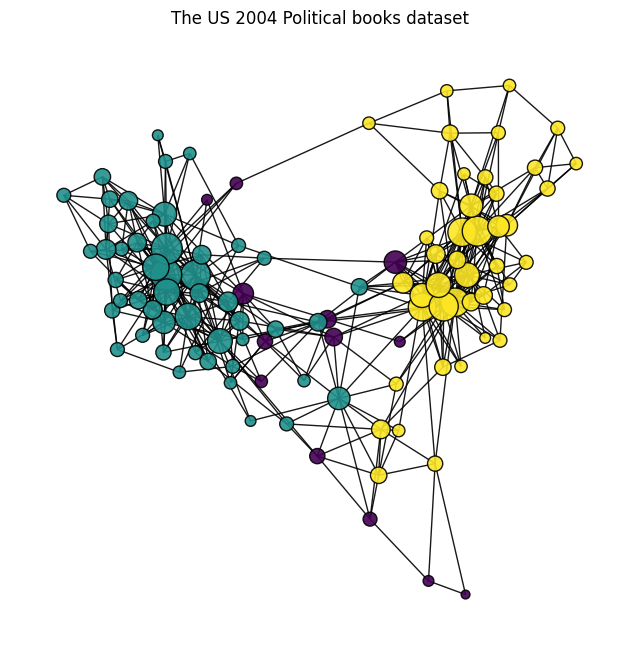

In [45]:
# Map each label to a number
id = 0
label_map = {}
for label in labels:
    if label not in label_map:
        label_map[label] = id
        id += 1

labels_as_numbers = [int(label_map[label]) for label in labels]

colors = ['r', 'b', 'g']

color_here = [colors[i] for i in labels_as_numbers]

color_to_name = [k for k, v in label_map.items()]
for i in range(len(color_to_name)):
        if color_to_name[i] == 'l':
                color_to_name[i] = "Liberal"
        elif color_to_name[i] == 'n':
                color_to_name[i] = 'Neutral'
        else:
                color_to_name[i] = 'Conservative'

plt.figure(figsize=(8,8))
# scale node size by degree
node_sizes = [v * 20 for v in dict(G.degree()).values()]
nx.draw_networkx(G, with_labels=False, node_color=labels_as_numbers, node_size= node_sizes,edgecolors="black", alpha=0.9)
plt.title("The US 2004 Political books dataset")
plt.axis("off")
plt.show()

## Showing DeepWalk

In [46]:
# adjmat , window_size , embedding_size , walks_per_vertex , walk_length , p , q
# n2v = Node2Vec(adjmat, 10, 128, 5, 5, 1, 1)
n2v = Node2Vec(adjmat, 10, 128, 10, 80, 1, 1)

In [47]:
n2v.train(30, 0.05)

INFO - 2023-11-29 12:26:37,570: collecting all words and their counts
INFO - 2023-11-29 12:26:37,571: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-29 12:26:37,582: collected 105 word types from a corpus of 84000 raw words and 1050 sentences
INFO - 2023-11-29 12:26:37,583: Creating a fresh vocabulary
INFO - 2023-11-29 12:26:37,585: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 105 unique words (100.00% of original 105, drops 0)', 'datetime': '2023-11-29T12:26:37.585033', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-29 12:26:37,585: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 84000 word corpus (100.00% of original 84000, drops 0)', 'datetime': '2023-11-29T12:26:37.585718', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', '

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


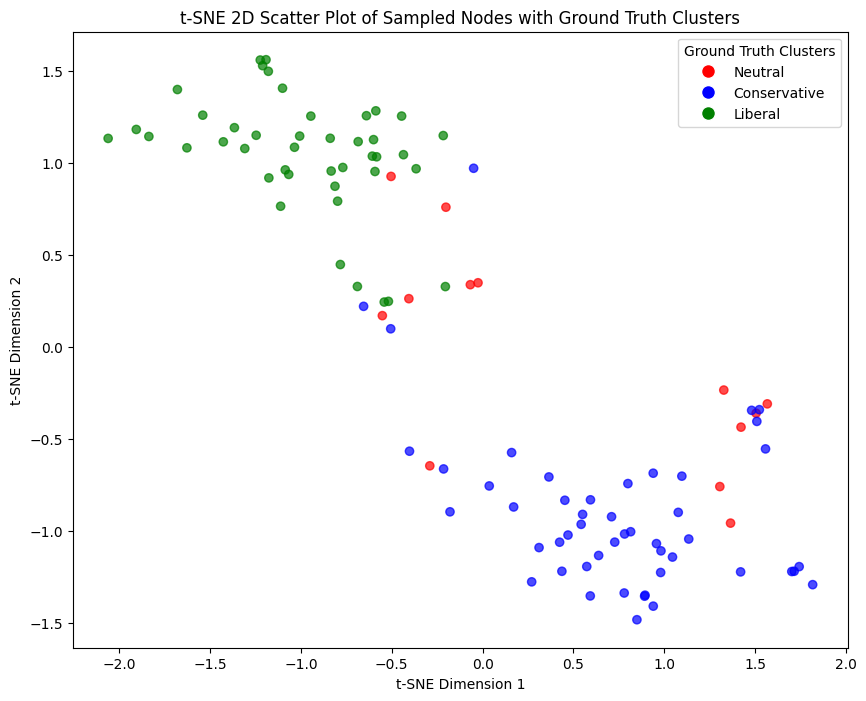

In [48]:
# # getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())

# Import standard scaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Get the ground truth labels for the sampled nodes
gt_labels_sampled = labels_as_numbers

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Standard scale
embeddings_2d = StandardScaler().fit_transform(embeddings_2d)

# Scatter plot in 2D with Louvain clusters as colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=color_here, cmap='tab10', alpha=0.7)

# Create a legend with specified labels and colors
unique_labels = colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=color_to_name[i]) for i, label in enumerate(colors)]
plt.legend(handles=legend_handles, title='Ground Truth Clusters', labels=[color_to_name[i] for i, label in enumerate(unique_labels)])

plt.title('t-SNE 2D Scatter Plot of Sampled Nodes with Ground Truth Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

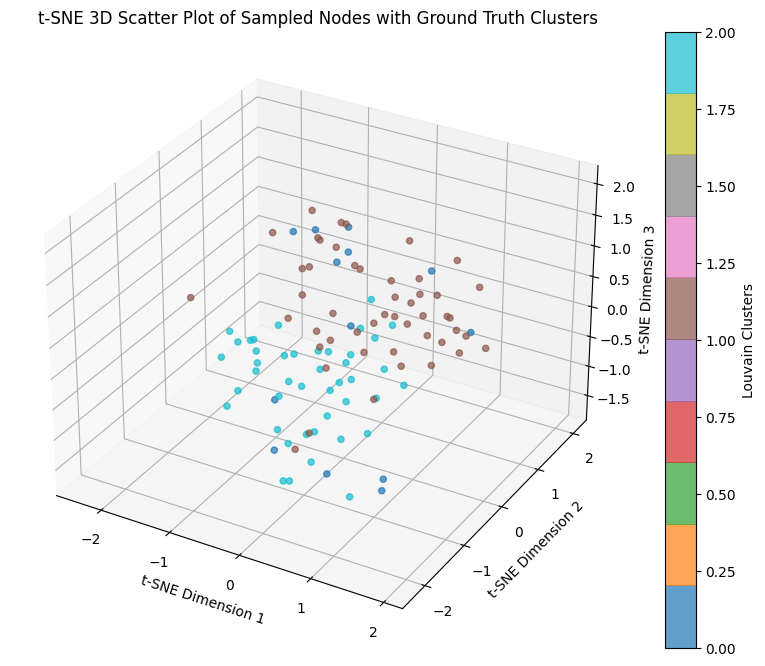

In [49]:
# # getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())

# Import standard scaler
from sklearn.preprocessing import StandardScaler

# Get the ground truth labels for the sampled nodes
gt_labels_sampled = labels_as_numbers

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Use t-SNE to reduce dimensions to 3D
tsne = TSNE(perplexity=10, n_components=3, learning_rate=20, init='random', n_iter=1000, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings_array)

# Standard scale
embeddings_3d = StandardScaler().fit_transform(embeddings_3d)

# Scatter plot in 3D with Louvain clusters as colors
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=gt_labels_sampled, cmap='tab10', alpha=0.7)
ax.set_title('t-SNE 3D Scatter Plot of Sampled Nodes with Ground Truth Clusters')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
fig.colorbar(scatter, label='Louvain Clusters')
plt.show()


# Deepwalk


In [50]:
# adjmat , window_size , embedding_size , walks_per_vertex , walk_length , p , q
# n2v = Node2Vec(adjmat, 10, 128, 5, 5, 1, 1)
n2v = Node2Vec(adjmat, 10, 128, 10, 80, 1, 1)

# Precompute embeddings for different walk lengths
possible_walk_lengths = [1, 5, 10, 20, 30, 50]  # Adjust as needed
embeddings_dict = {}

for walk_length in possible_walk_lengths:
    # Train Node2Vec for each walk length
    n2v = Node2Vec(adjmat, 10, 128, 10, walk_length=walk_length, p=1, q=1)
    n2v.train(30, 0.05)

    # Get embeddings
    embeddings = n2v.get_embeddings()
    embeddings_dict[walk_length] = embeddings

INFO - 2023-11-29 12:26:41,387: collecting all words and their counts
INFO - 2023-11-29 12:26:41,388: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-29 12:26:41,389: collected 105 word types from a corpus of 2100 raw words and 1050 sentences
INFO - 2023-11-29 12:26:41,390: Creating a fresh vocabulary
INFO - 2023-11-29 12:26:41,391: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 105 unique words (100.00% of original 105, drops 0)', 'datetime': '2023-11-29T12:26:41.391260', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-29 12:26:41,392: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 2100 word corpus (100.00% of original 2100, drops 0)', 'datetime': '2023-11-29T12:26:41.392074', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'pla

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


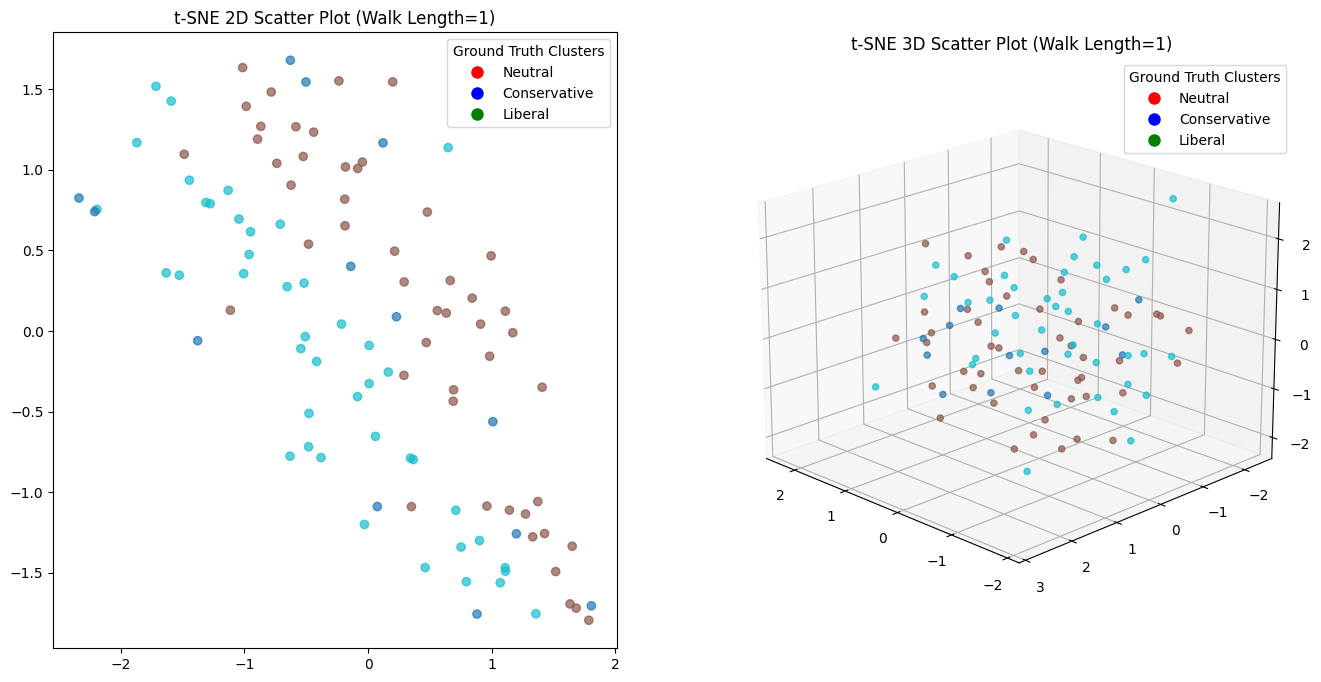

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


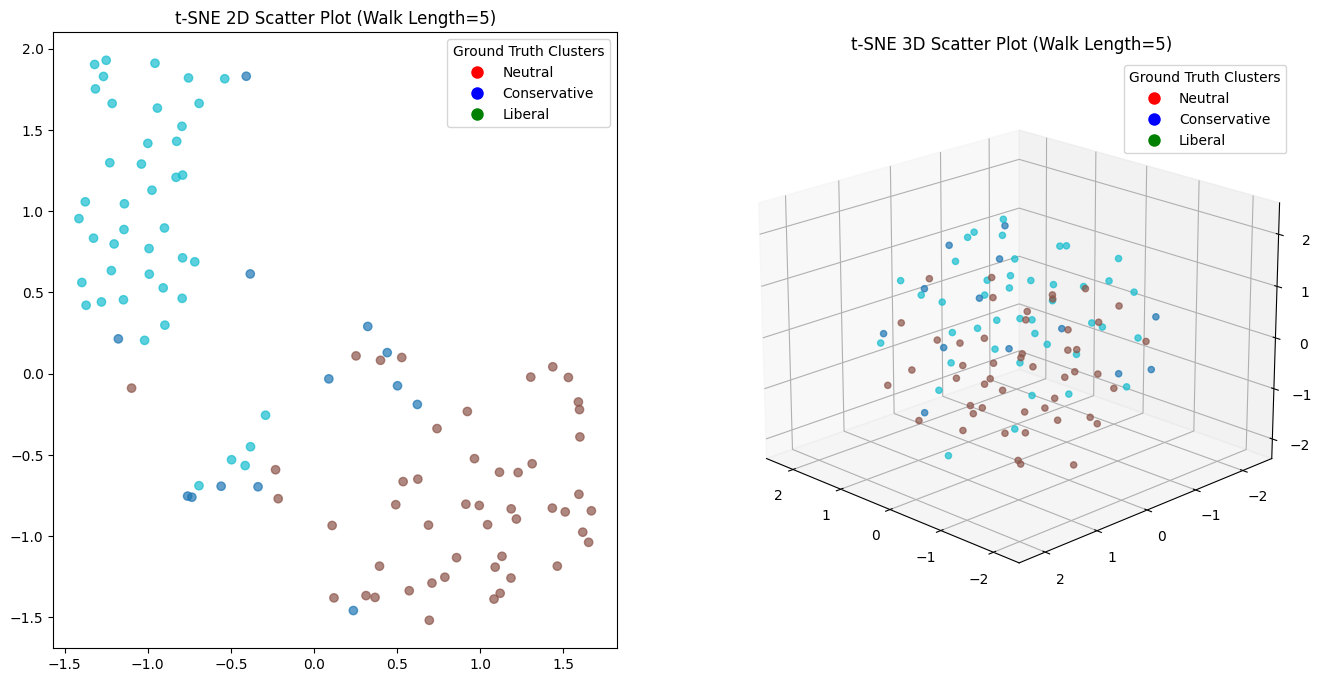

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


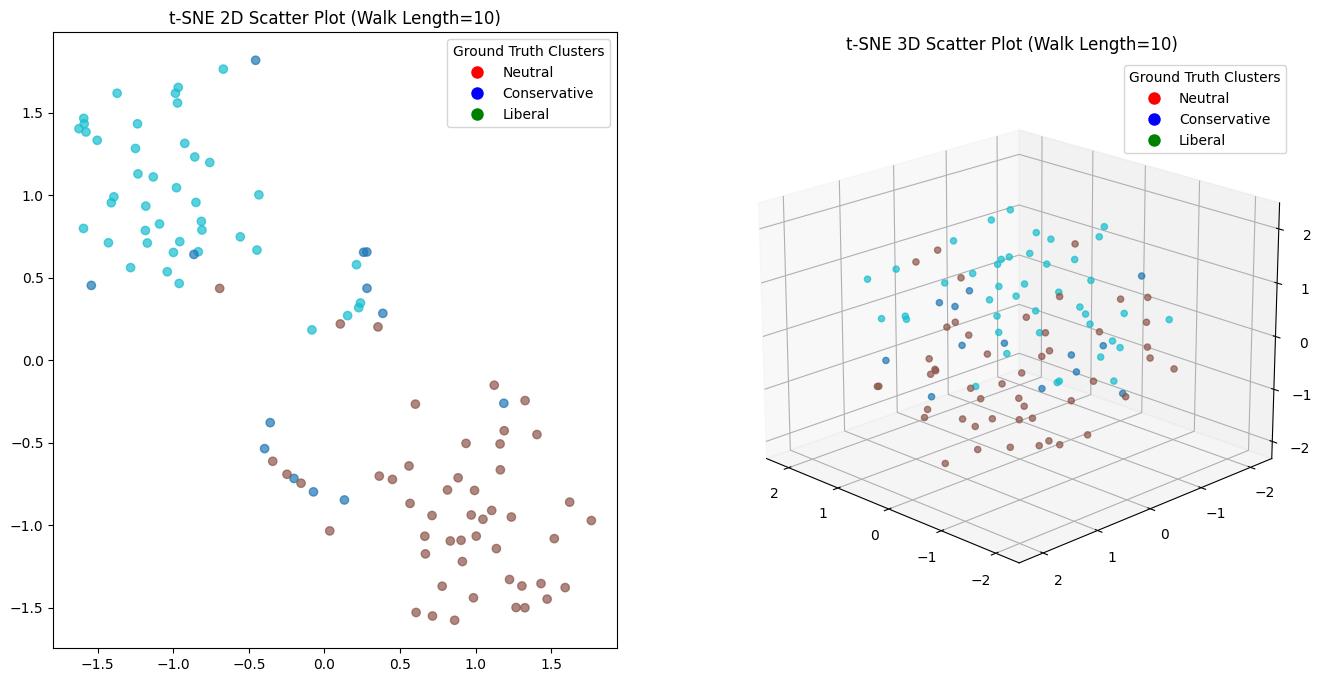

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


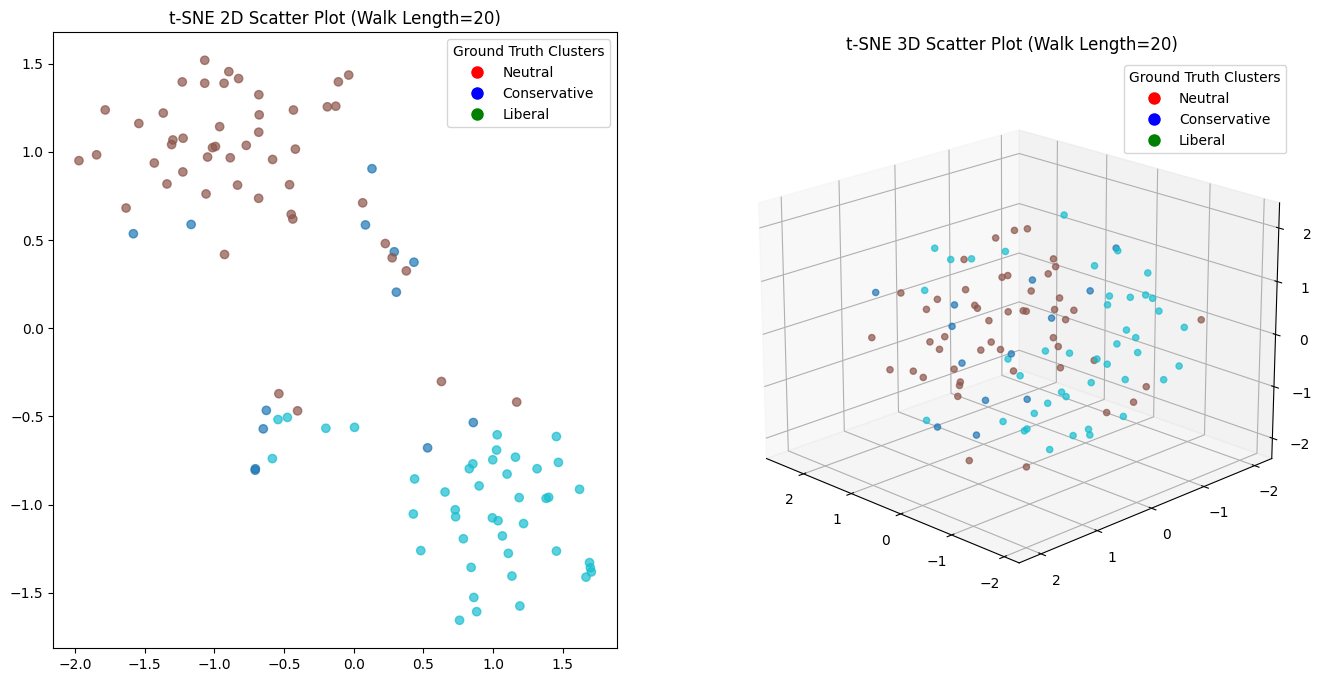

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


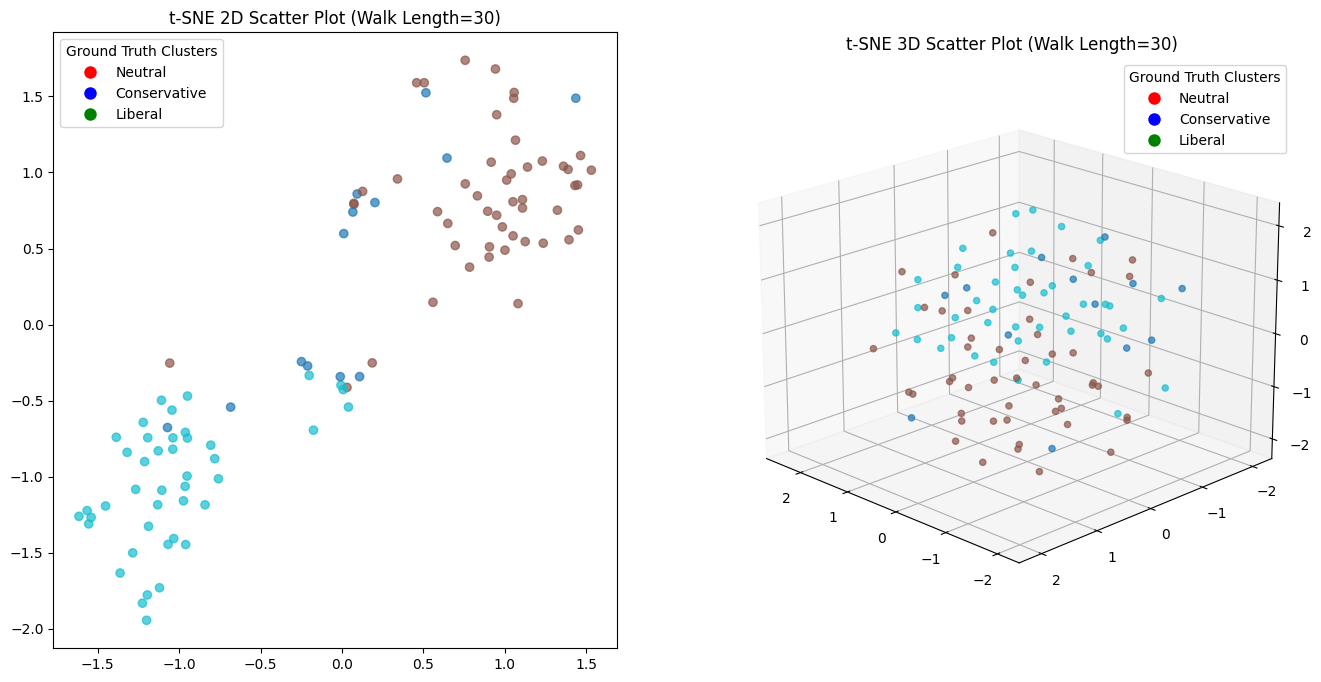

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


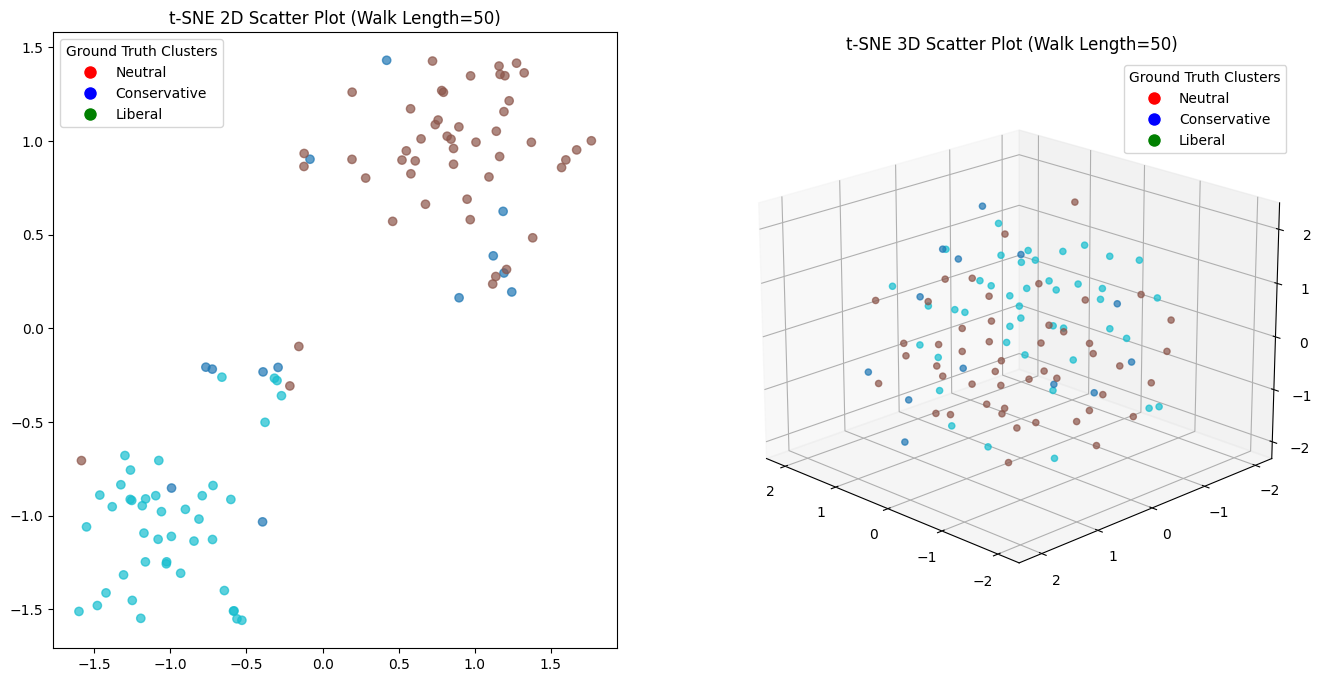

In [51]:
def plot_tSNE_subplots(embeddings, gt_labels, figsize=(16, 8), colors=None, color_to_name=None, walk_length=None):
    # Convert the list of embeddings to a NumPy array
    embeddings_array = np.array(embeddings)

    # Use t-SNE to reduce dimensions to 2D
    tsne_2d = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne_2d.fit_transform(embeddings_array)
    embeddings_2d = StandardScaler().fit_transform(embeddings_2d)

    # Use t-SNE to reduce dimensions to 3D
    tsne_3d = TSNE(n_components=3, random_state=42)
    embeddings_3d = tsne_3d.fit_transform(embeddings_array)
    embeddings_3d = StandardScaler().fit_transform(embeddings_3d)

    # Plot 2D t-SNE
    plt.figure(figsize=figsize)
    ax1 = plt.subplot(1, 2, 1)
    scatter_2d = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=gt_labels, cmap='tab10', alpha=0.7)
    ax1.set_title(f't-SNE 2D Scatter Plot (Walk Length={walk_length})')
    if colors and color_to_name:
        unique_labels = np.unique(gt_labels)
        legend_handles_2d = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=color_to_name[i]) for i in unique_labels]
        ax1.legend(handles=legend_handles_2d, title='Ground Truth Clusters')

    # Plot 3D t-SNE
    ax2 = plt.subplot(1, 2, 2, projection='3d')
    scatter_3d = ax2.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=gt_labels, cmap='tab10', alpha=0.7)
    ax2.set_title(f't-SNE 3D Scatter Plot (Walk Length={walk_length})')
    if colors and color_to_name:
        unique_labels = np.unique(gt_labels)
        legend_handles_3d = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=color_to_name[i]) for i in unique_labels]
        ax2.legend(handles=legend_handles_3d, title='Ground Truth Clusters')

    # Rotate the plot along the z-axis by 90 degrees
    ax2.view_init(elev=20, azim=135)

    # Save img as polbook_dw_{walk_len}
    plt.savefig(f'polbook_dw_{walk_length}.png')

    plt.show()

# Example usage:
# Assuming you have gt_labels, colors, and color_to_name
for walk_length, embeddings in embeddings_dict.items():
    plot_tSNE_subplots(embeddings, gt_labels_sampled, figsize=(16, 8), colors=colors, color_to_name=color_to_name, walk_length=walk_length)

In [52]:
# Precompute embeddings for different walk lengths
possible_walk_lengths = [1, 5, 10, 20, 30, 50]  # Adjust as needed
embeddings_dict = {}

for walk_length in possible_walk_lengths:
    # Train Node2Vec for each walk length
    n2v = Node2Vec(adjmat, 10, 128, 10, walk_length=walk_length, p=1, q=0.5)
    n2v.train(30, 0.05)

    # Get embeddings
    embeddings = n2v.get_embeddings()
    embeddings_dict[walk_length] = embeddings

INFO - 2023-11-29 12:26:55,667: collecting all words and their counts
INFO - 2023-11-29 12:26:55,669: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-29 12:26:55,670: collected 105 word types from a corpus of 2100 raw words and 1050 sentences
INFO - 2023-11-29 12:26:55,671: Creating a fresh vocabulary
INFO - 2023-11-29 12:26:55,672: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 105 unique words (100.00% of original 105, drops 0)', 'datetime': '2023-11-29T12:26:55.672340', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-29 12:26:55,673: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 2100 word corpus (100.00% of original 2100, drops 0)', 'datetime': '2023-11-29T12:26:55.672994', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'pla

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


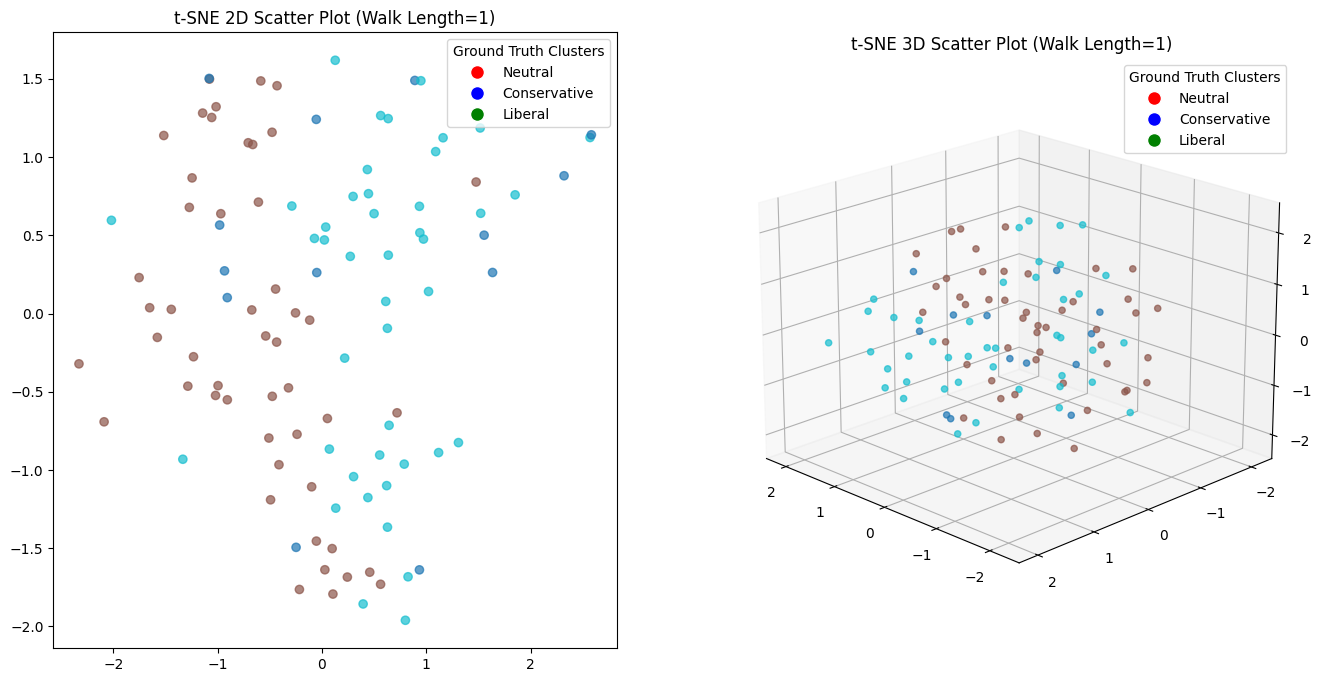

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


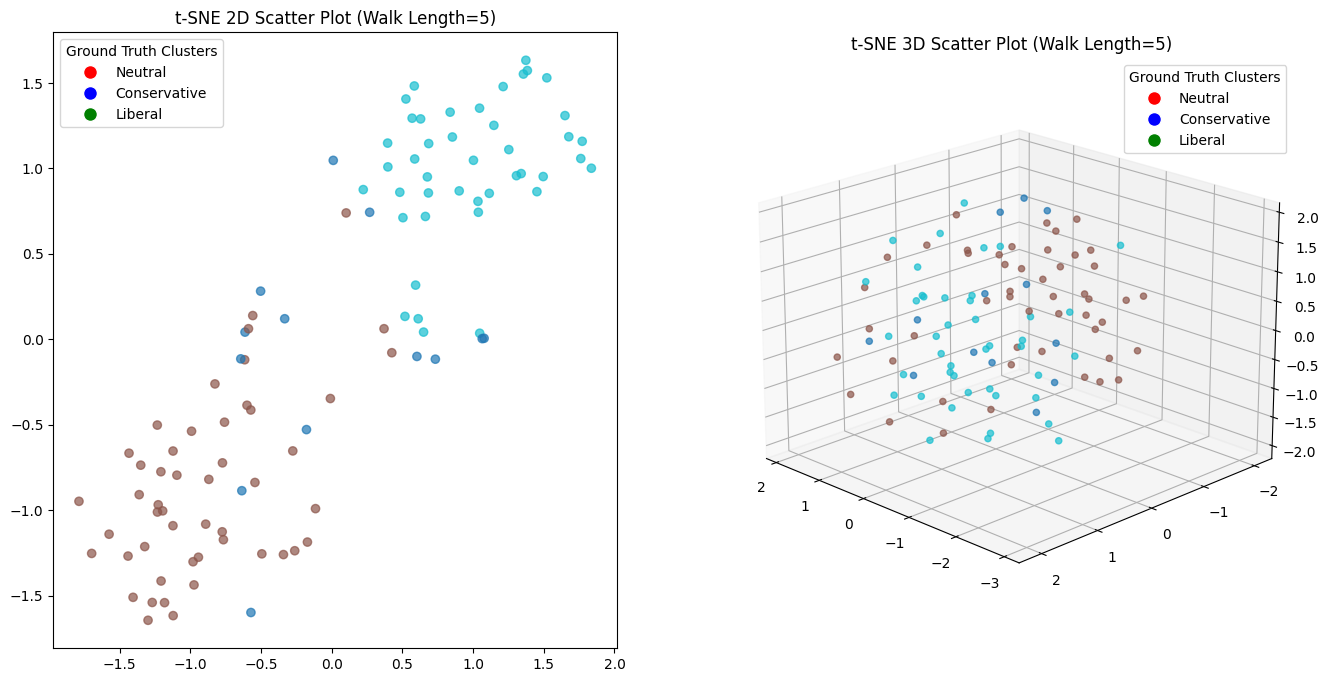

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


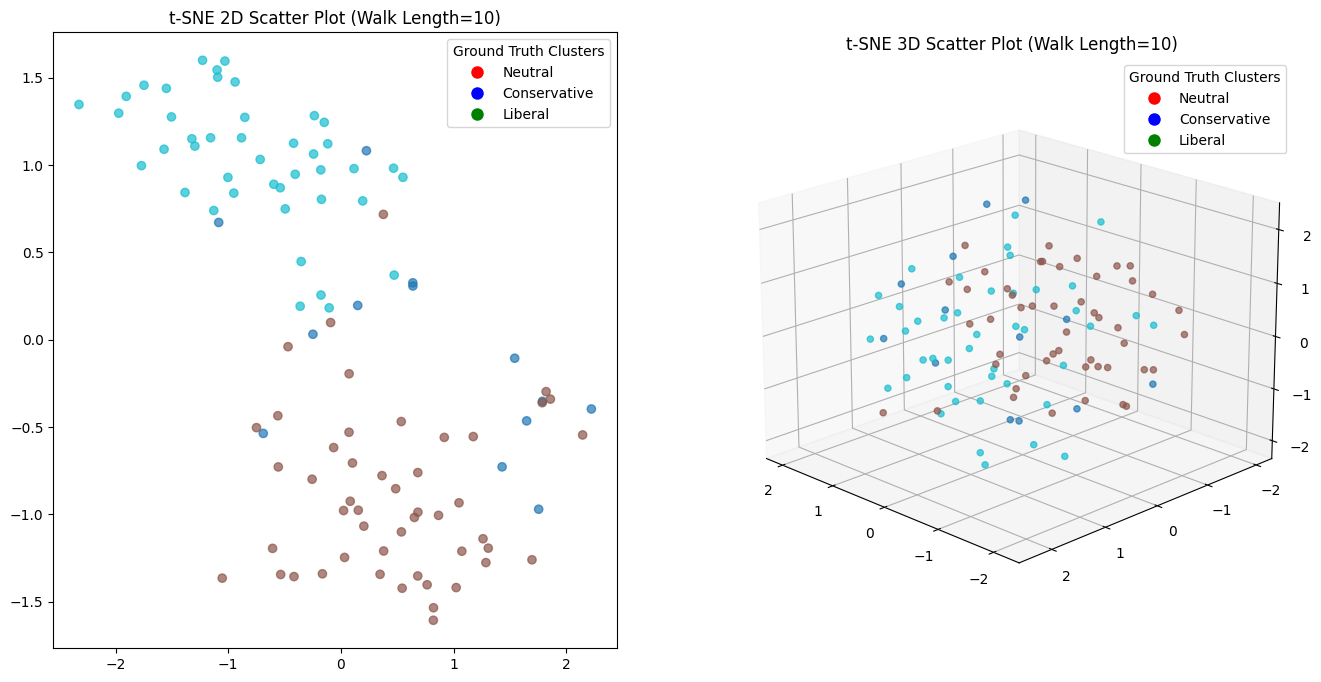

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


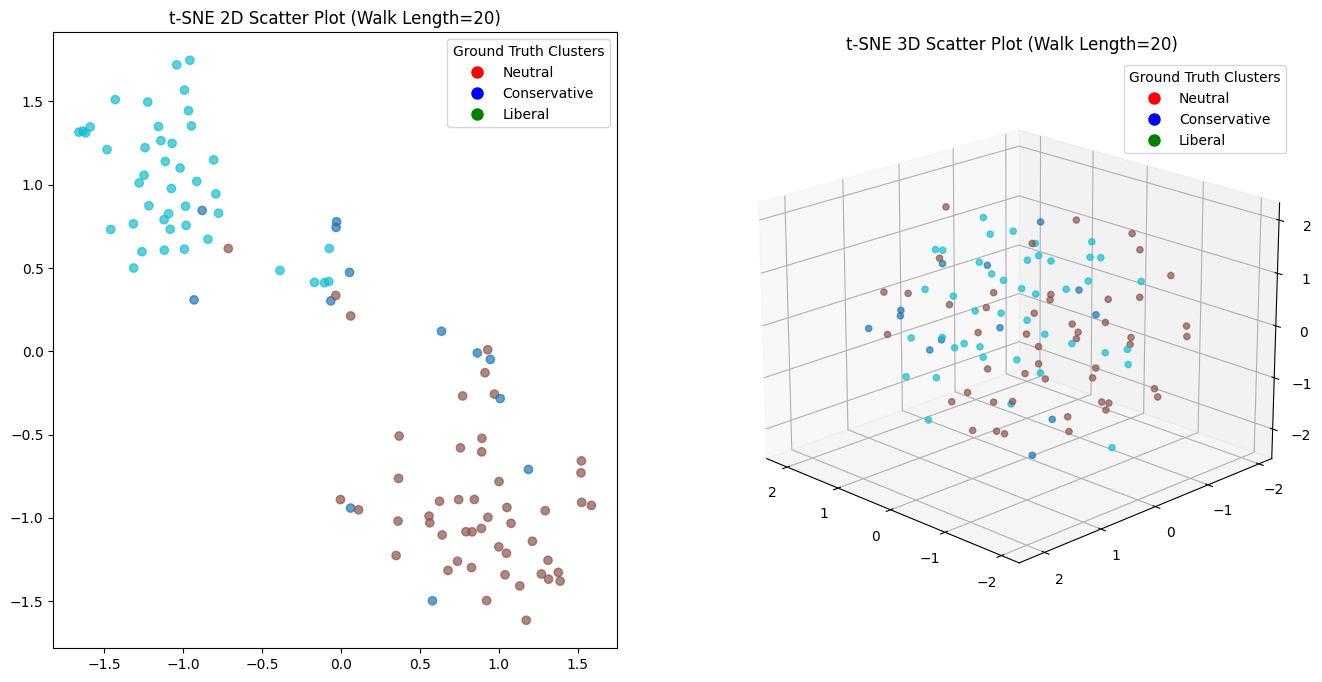

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


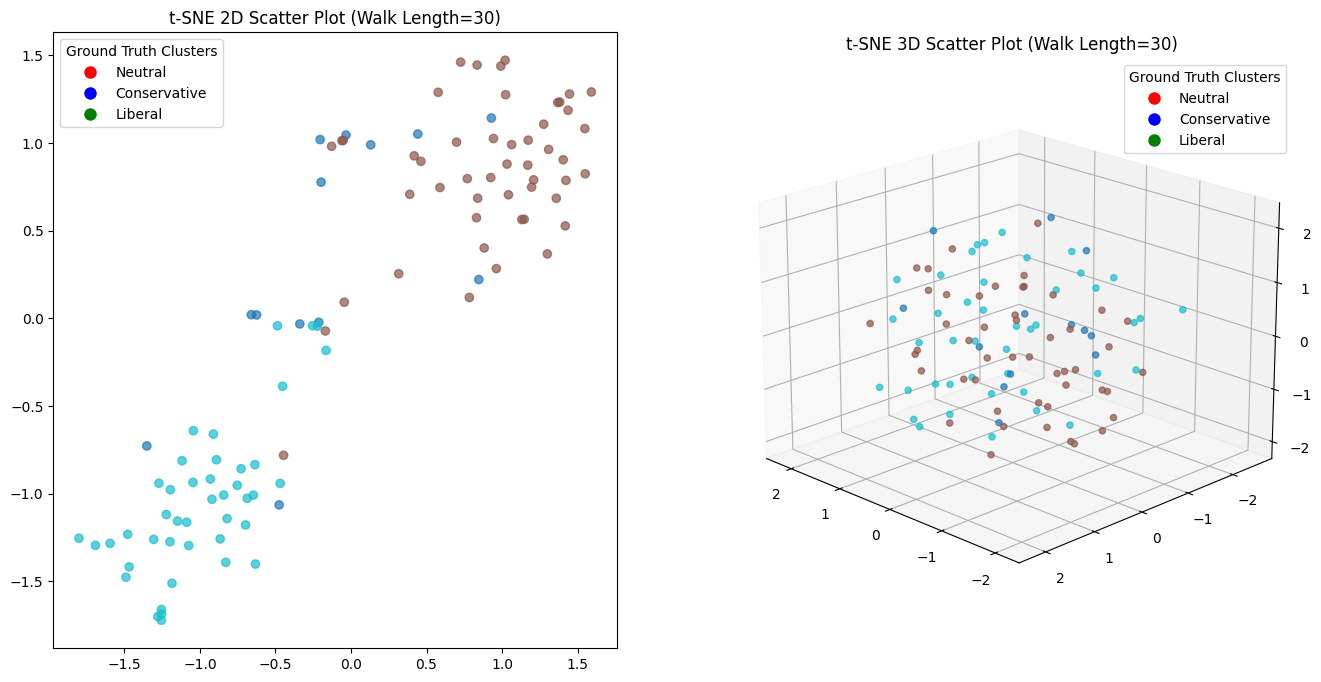

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


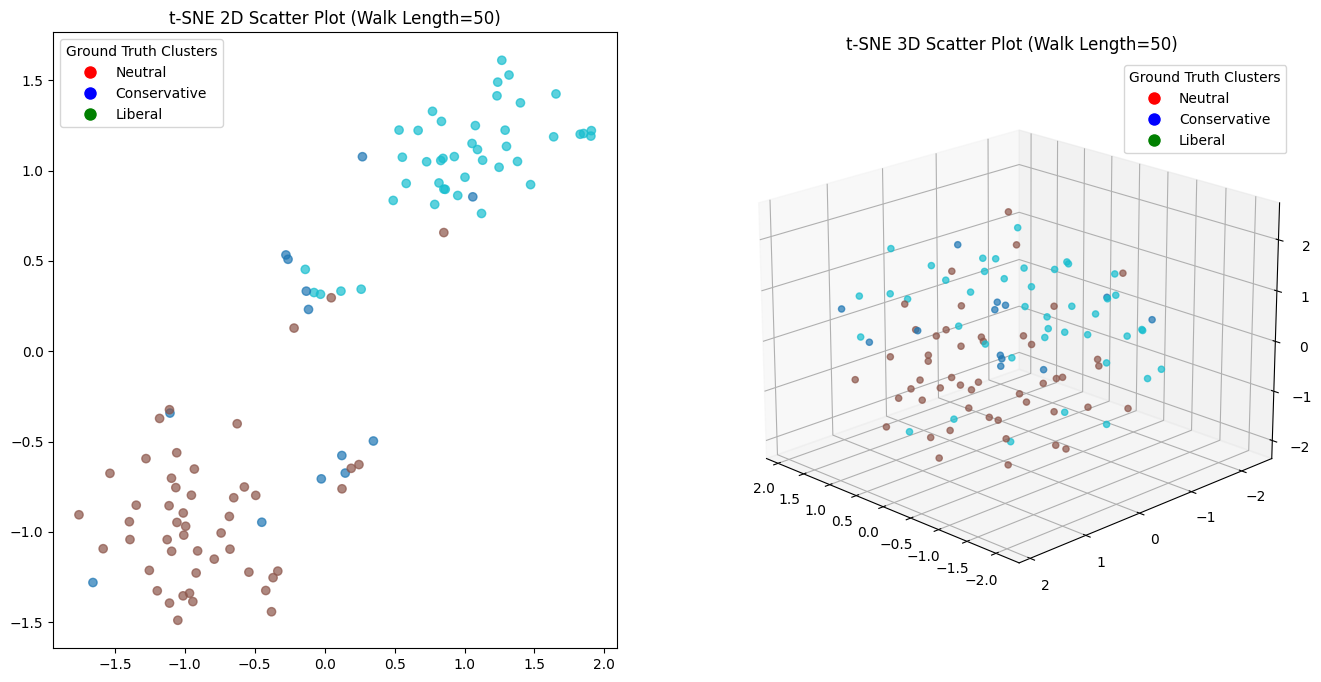

In [53]:
def plot_tSNE_subplots(embeddings, gt_labels, figsize=(16, 8), colors=None, color_to_name=None, walk_length=None):
    # Convert the list of embeddings to a NumPy array
    embeddings_array = np.array(embeddings)

    # Use t-SNE to reduce dimensions to 2D
    tsne_2d = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne_2d.fit_transform(embeddings_array)
    embeddings_2d = StandardScaler().fit_transform(embeddings_2d)

    # Use t-SNE to reduce dimensions to 3D
    tsne_3d = TSNE(n_components=3, random_state=42)
    embeddings_3d = tsne_3d.fit_transform(embeddings_array)
    embeddings_3d = StandardScaler().fit_transform(embeddings_3d)

    # Plot 2D t-SNE
    plt.figure(figsize=figsize)
    ax1 = plt.subplot(1, 2, 1)
    scatter_2d = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=gt_labels, cmap='tab10', alpha=0.7)
    ax1.set_title(f't-SNE 2D Scatter Plot (Walk Length={walk_length})')
    if colors and color_to_name:
        unique_labels = np.unique(gt_labels)
        legend_handles_2d = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=color_to_name[i]) for i in unique_labels]
        ax1.legend(handles=legend_handles_2d, title='Ground Truth Clusters')

    # Plot 3D t-SNE
    ax2 = plt.subplot(1, 2, 2, projection='3d')
    scatter_3d = ax2.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=gt_labels, cmap='tab10', alpha=0.7)
    ax2.set_title(f't-SNE 3D Scatter Plot (Walk Length={walk_length})')
    if colors and color_to_name:
        unique_labels = np.unique(gt_labels)
        legend_handles_3d = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=color_to_name[i]) for i in unique_labels]
        ax2.legend(handles=legend_handles_3d, title='Ground Truth Clusters')

    # Rotate the plot along the z-axis by 90 degrees
    ax2.view_init(elev=20, azim=135)

    # Save img as polbook_dw_{walk_len}
    plt.savefig(f'polbook_n2v_{walk_length}_1_0.5.png')

    plt.show()

# Example usage:
# Assuming you have gt_labels, colors, and color_to_name
for walk_length, embeddings in embeddings_dict.items():
    plot_tSNE_subplots(embeddings, gt_labels_sampled, figsize=(16, 8), colors=colors, color_to_name=color_to_name, walk_length=walk_length)

In [54]:
# Precompute embeddings for different walk lengths
possible_walk_lengths = [1, 5, 10, 20, 30, 50]  # Adjust as needed
embeddings_dict = {}

for walk_length in possible_walk_lengths:
    # Train Node2Vec for each walk length
    n2v = Node2Vec(adjmat, 10, 128, 10, walk_length=walk_length, p=0.5, q=1)
    n2v.train(30, 0.05)

    # Get embeddings
    embeddings = n2v.get_embeddings()
    embeddings_dict[walk_length] = embeddings

INFO - 2023-11-29 12:27:12,024: collecting all words and their counts
INFO - 2023-11-29 12:27:12,025: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-29 12:27:12,028: collected 105 word types from a corpus of 2100 raw words and 1050 sentences
INFO - 2023-11-29 12:27:12,031: Creating a fresh vocabulary
INFO - 2023-11-29 12:27:12,033: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 105 unique words (100.00% of original 105, drops 0)', 'datetime': '2023-11-29T12:27:12.032963', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-29 12:27:12,034: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 2100 word corpus (100.00% of original 2100, drops 0)', 'datetime': '2023-11-29T12:27:12.034603', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'pla

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


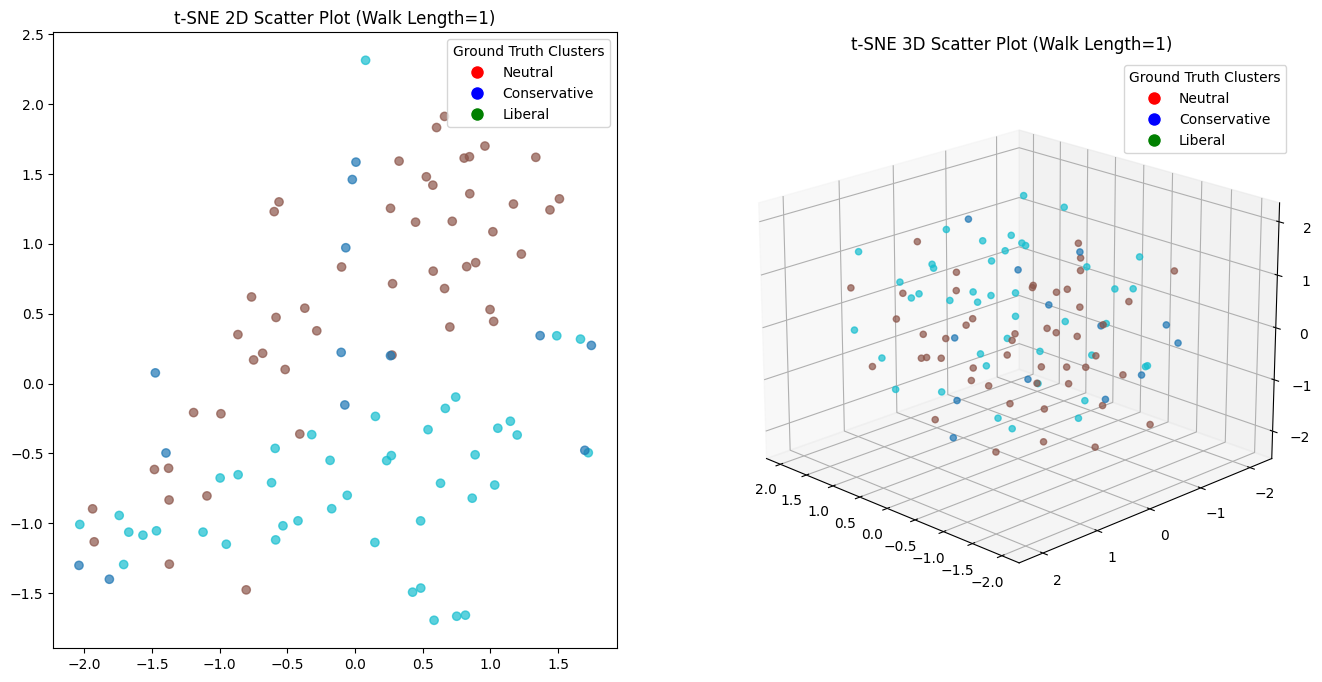

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


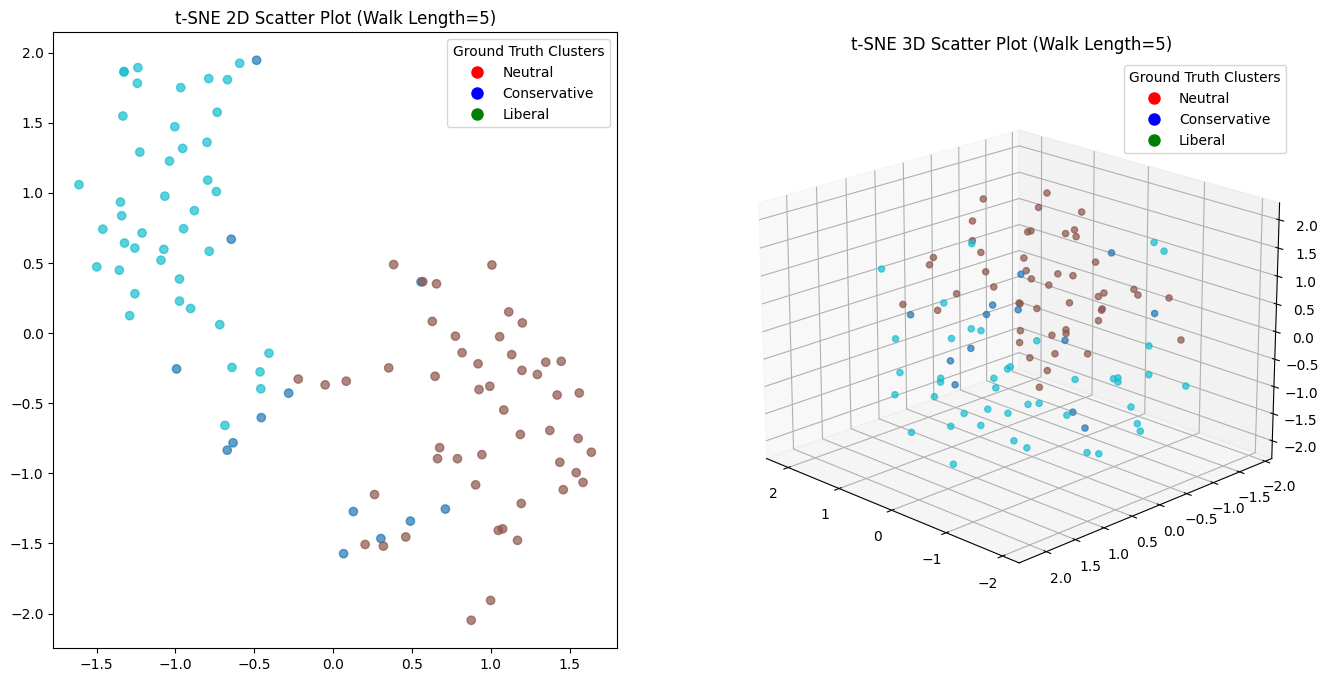

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


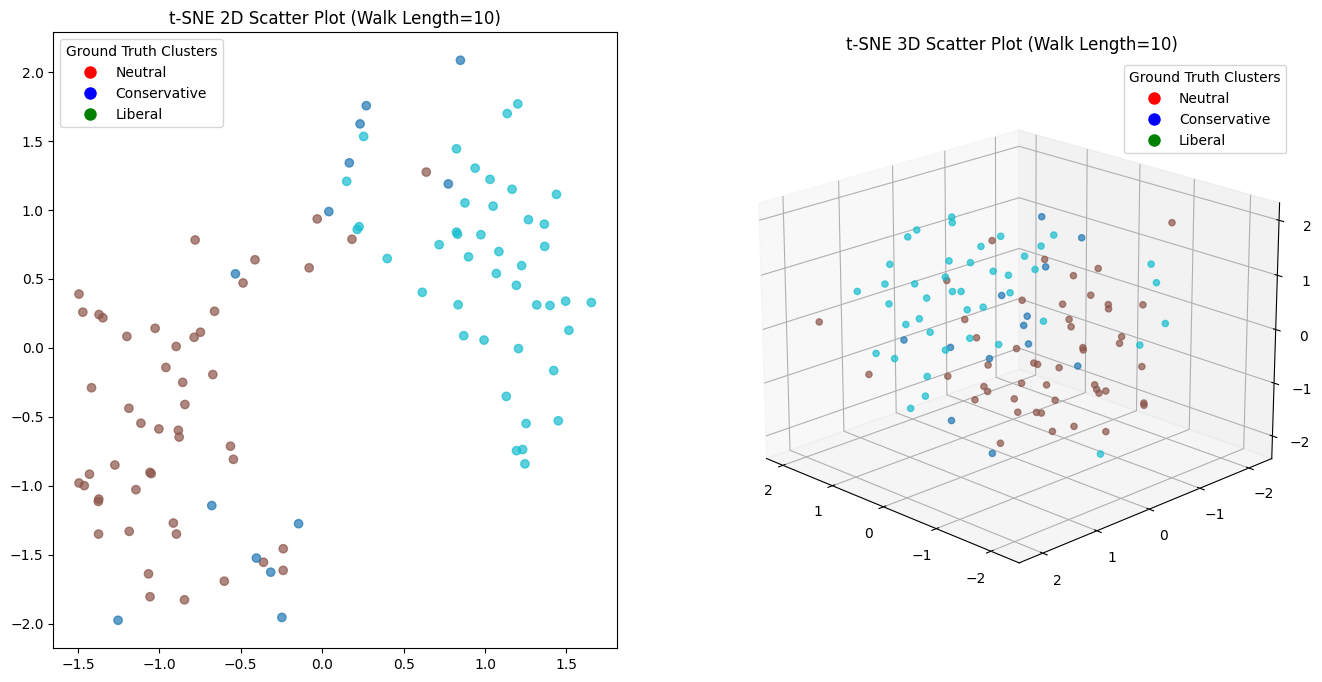

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


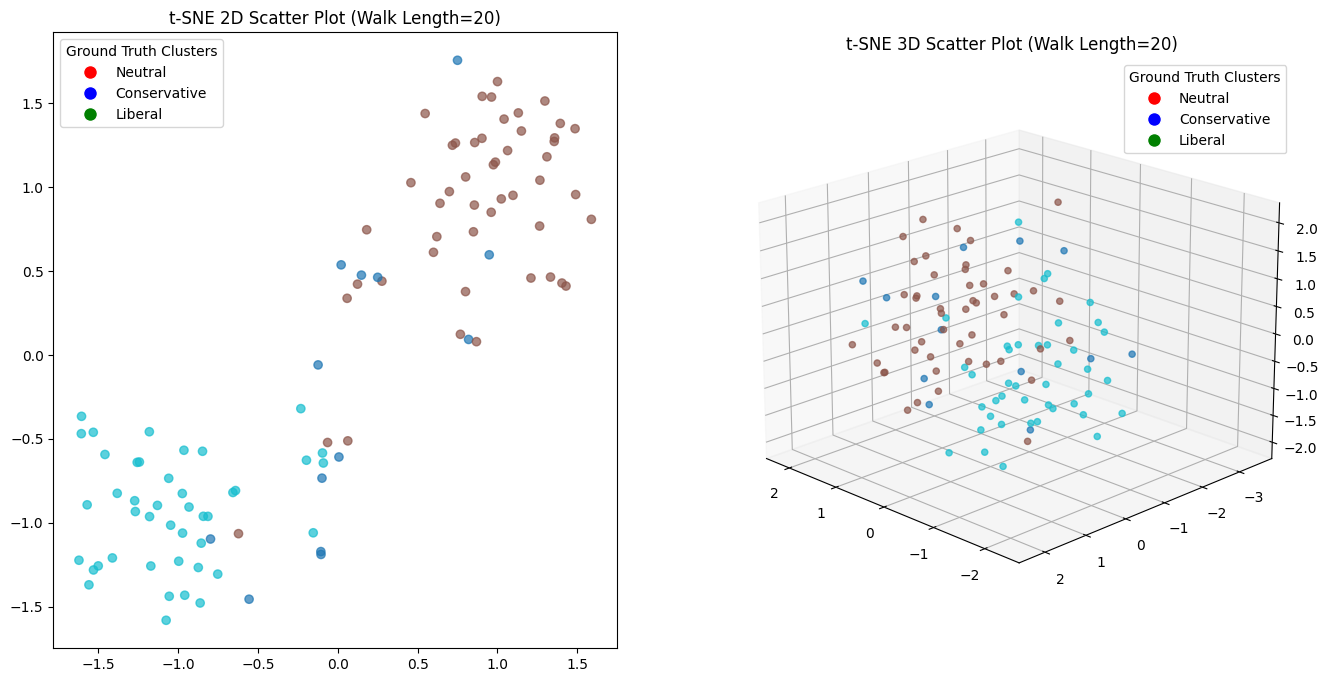

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


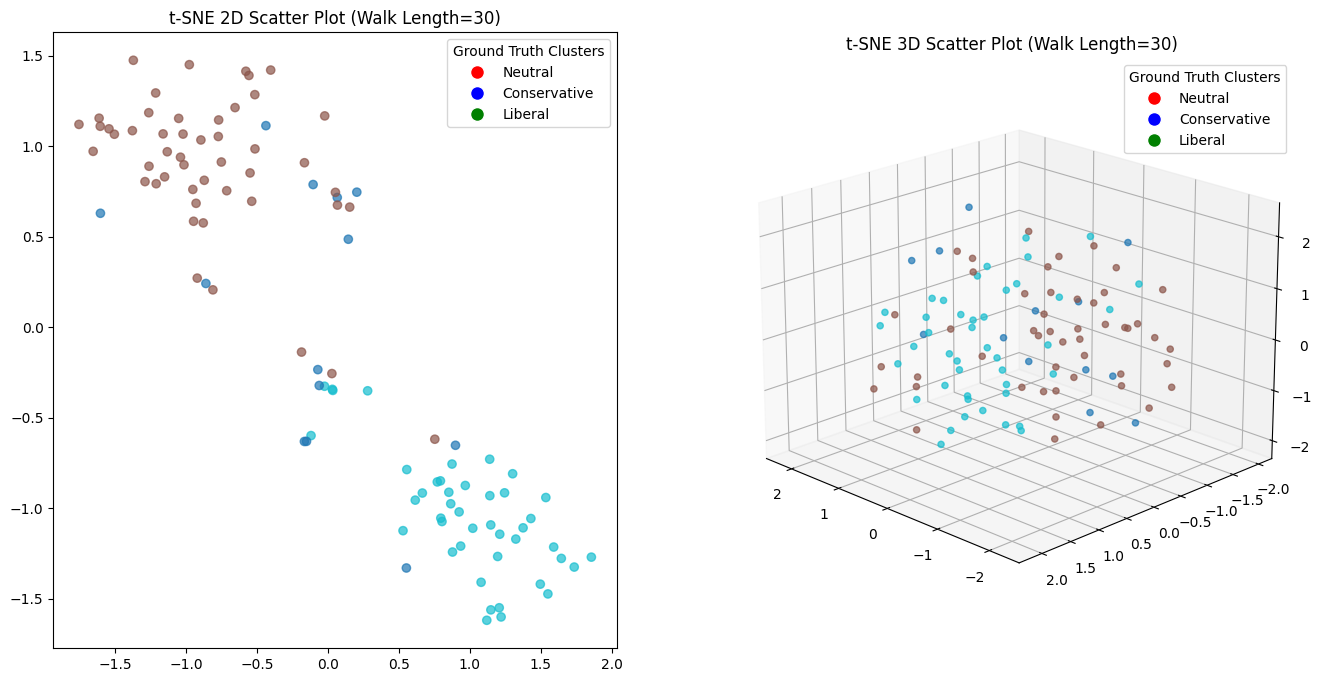

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


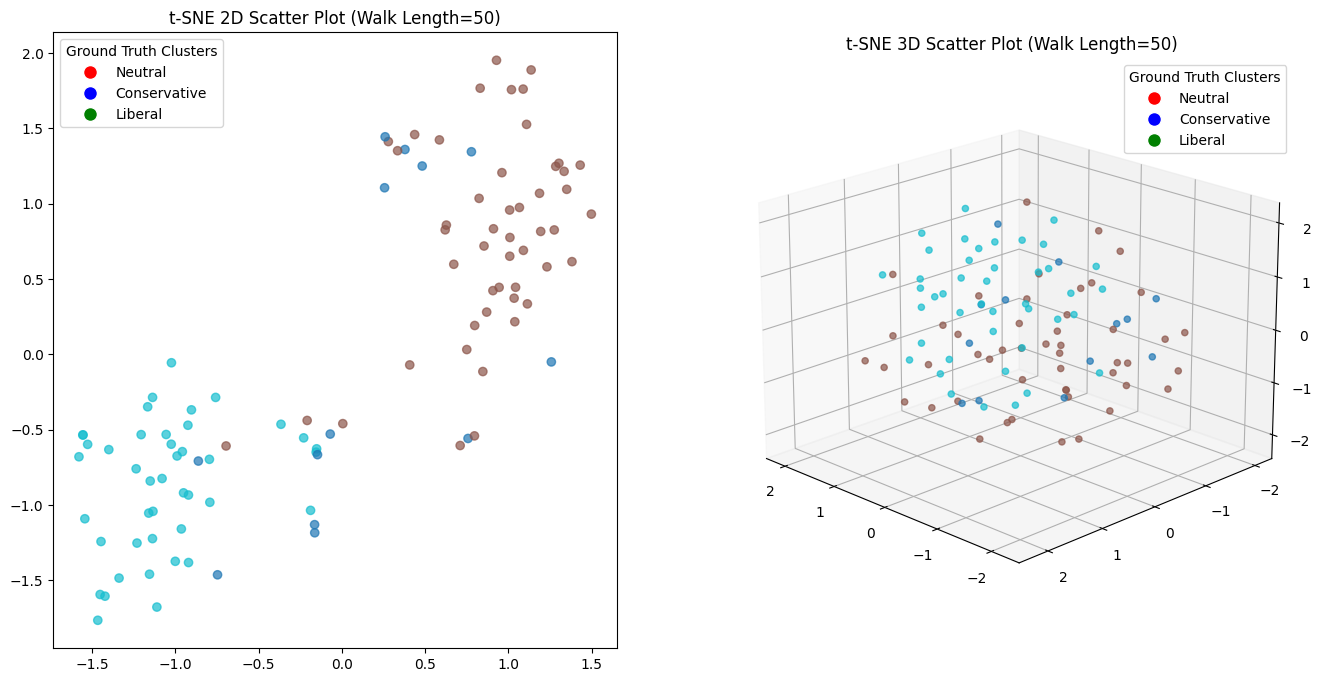

In [55]:
def plot_tSNE_subplots(embeddings, gt_labels, figsize=(16, 8), colors=None, color_to_name=None, walk_length=None):
    # Convert the list of embeddings to a NumPy array
    embeddings_array = np.array(embeddings)

    # Use t-SNE to reduce dimensions to 2D
    tsne_2d = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne_2d.fit_transform(embeddings_array)
    embeddings_2d = StandardScaler().fit_transform(embeddings_2d)

    # Use t-SNE to reduce dimensions to 3D
    tsne_3d = TSNE(n_components=3, random_state=42)
    embeddings_3d = tsne_3d.fit_transform(embeddings_array)
    embeddings_3d = StandardScaler().fit_transform(embeddings_3d)

    # Plot 2D t-SNE
    plt.figure(figsize=figsize)
    ax1 = plt.subplot(1, 2, 1)
    scatter_2d = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=gt_labels, cmap='tab10', alpha=0.7)
    ax1.set_title(f't-SNE 2D Scatter Plot (Walk Length={walk_length})')
    if colors and color_to_name:
        unique_labels = np.unique(gt_labels)
        legend_handles_2d = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=color_to_name[i]) for i in unique_labels]
        ax1.legend(handles=legend_handles_2d, title='Ground Truth Clusters')

    # Plot 3D t-SNE
    ax2 = plt.subplot(1, 2, 2, projection='3d')
    scatter_3d = ax2.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=gt_labels, cmap='tab10', alpha=0.7)
    ax2.set_title(f't-SNE 3D Scatter Plot (Walk Length={walk_length})')
    if colors and color_to_name:
        unique_labels = np.unique(gt_labels)
        legend_handles_3d = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=color_to_name[i]) for i in unique_labels]
        ax2.legend(handles=legend_handles_3d, title='Ground Truth Clusters')

    # Rotate the plot along the z-axis by 90 degrees
    ax2.view_init(elev=20, azim=135)

    # Save img as polbook_dw_{walk_len}
    plt.savefig(f'polbook_n2v_{walk_length}_0.5_1.png')

    plt.show()

# Example usage:
# Assuming you have gt_labels, colors, and color_to_name
for walk_length, embeddings in embeddings_dict.items():
    plot_tSNE_subplots(embeddings, gt_labels_sampled, figsize=(16, 8), colors=colors, color_to_name=color_to_name, walk_length=walk_length)